<a href="https://colab.research.google.com/github/jashwant16300/English-Manipuri-Translation-Analysis/blob/main/Comparative_Analysis_NLLB_vs_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Hugging Face transformers, evaluation metrics, and translation tools
!pip install -q transformers torch pandas sacrebleu sentencepiece deep-translator

In [2]:
import pandas as pd

# Creating a small test dataset (Parallel Corpus)
# We include English, and the correct human translations in Bengali script & Meetei Mayek
data = {
    "English": [
        "I am a student.",
        "What is your name?",
        "Education is very important.",
        "Where are you going?"
    ],
    "True_Manipuri_Bengali": [
        "ঐ মহৈরোই অমনি।",
        "নমিং করি কৌবগে?",
        "লাইরিক তম্বা অসি য়াম্না মরু ওই।",
        "নহাক কদাইদা চৎকদবা?"
    ],
    "True_Manipuri_Meetei": [
        "ꯑꯩ ꯃꯍꯩꯔꯣꯏ ꯑꯃꯅꯤ꯫",
        "ꯅꯃꯤꯡ ꯀꯔꯤ ꯀꯧꯕꯒꯦ?",
        "ꯂꯥꯏꯔꯤꯛ ꯇꯝꯕꯥ ꯑꯁꯤ ꯌꯥꯝꯅꯥ ꯃꯔꯨ ꯑꯣꯏ꯫",
        "ꯅꯍꯥꯛ ꯀꯗꯥꯏꯗꯥ ꯆꯠꯀꯗꯕꯥ?"
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)
display(df)

,English,True_Manipuri_Bengali,True_Manipuri_Meetei
0,I am a student.,ঐ মহৈরোই অমনি।,ꯑꯩ ꯃꯍꯩꯔꯣꯏ ꯑꯃꯅꯤ꯫
1,What is your name?,নমিং করি কৌবগে?,ꯅꯃꯤꯡ ꯀꯔꯤ ꯀꯧꯕꯒꯦ?
2,Education is very important.,লাইরিক তম্বা অসি য়াম্না মরু ওই।,ꯂꯥꯏꯔꯤꯛ ꯇꯝꯕꯥ ꯑꯁꯤ ꯌꯥꯝꯅꯥ ꯃꯔꯨ ꯑꯣꯏ꯫
3,Where are you going?,নহাক কদাইদা চৎকদবা?,ꯅꯍꯥꯛ ꯀꯗꯥꯏꯗꯥ ꯆꯠꯀꯗꯕꯥ?


In [5]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

print("Loading NLLB Model...")
model_name = "facebook/nllb-200-distilled-600M"

# We use use_fast=False to ensure compatibility, or we use convert_tokens_to_ids
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(f"Model loaded on {device}!")

# Corrected Function to translate text
def translate_nllb(text, target_lang_code):
    inputs = tokenizer(text, return_tensors="pt").to(device)

    # FIX: Use convert_tokens_to_ids instead of lang_code_to_id
    target_lang_id = tokenizer.convert_tokens_to_ids(target_lang_code)

    translated_tokens = model.generate(
        **inputs,
        forced_bos_token_id=target_lang_id,
        max_length=100
    )
    return tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]

# 1. Translate to Manipuri (Bengali Script)
print("Translating to Bengali Script...")
df['NLLB_Pred_Bengali'] = df['English'].apply(lambda x: translate_nllb(x, "mni_Beng"))

# 2. Translate to Manipuri (Meetei Mayek Script)
print("Translating to Meetei Mayek...")
df['NLLB_Pred_Meetei'] = df['English'].apply(lambda x: translate_nllb(x, "mni_Mtei"))

print("Translation Complete! Here are the results:")
display(df[['English', 'NLLB_Pred_Bengali', 'NLLB_Pred_Meetei']])

Loading NLLB Model...


Loading weights:   0%|          | 0/512 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Model loaded on cuda!
Translating to Bengali Script...
Translating to Meetei Mayek...
Translation Complete! Here are the results:


,English,NLLB_Pred_Bengali,NLLB_Pred_Meetei
0,I am a student.,ঐহাক্না মহৈরোয় অমনি।,I am a student.
1,What is your name?,অদোমগী মিংদু করিনো?,What's your name?
2,Education is very important.,এজুকেসন হায়বসি য়াম্না মরুওই।,Education is very important.
3,Where are you going?,অদোম কদায়দা চঙলি?,Where are you going?


In [7]:
from deep_translator import GoogleTranslator

print("Running Google Translate Baseline...")

# Function for Google Translate
def translate_google(text, target_lang):
    try:
        return GoogleTranslator(source='en', target=target_lang).translate(text)
    except Exception as e:
        return f"Error: {e}"

# Google Translate uses 'bn' for Bengali language, and 'mni-Mtei' for Meetei Mayek
df['Google_Pred_Bengali'] = df['English'].apply(lambda x: translate_google(x, 'bn'))
df['Google_Pred_Meetei'] = df['English'].apply(lambda x: translate_google(x, 'mni-Mtei'))

print("\n Master Comparative Table:")
# Reordering columns to show them side-by-side for easy comparison
final_columns = [
    'English',
    'True_Manipuri_Bengali', 'NLLB_Pred_Bengali', 'Google_Pred_Bengali',
    'True_Manipuri_Meetei', 'NLLB_Pred_Meetei', 'Google_Pred_Meetei'
]
display(df[final_columns])

Running Google Translate Baseline...

 Master Comparative Table:


,English,True_Manipuri_Bengali,NLLB_Pred_Bengali,Google_Pred_Bengali,True_Manipuri_Meetei,NLLB_Pred_Meetei,Google_Pred_Meetei
0,I am a student.,ঐ মহৈরোই অমনি।,ঐহাক্না মহৈরোয় অমনি।,আমি একজন ছাত্র।,ꯑꯩ ꯃꯍꯩꯔꯣꯏ ꯑꯃꯅꯤ꯫,I am a student.,ꯑꯩꯍꯥꯛ ꯃꯍꯩꯔꯣꯌ ꯑꯃꯅꯤ꯫
1,What is your name?,নমিং করি কৌবগে?,অদোমগী মিংদু করিনো?,তোমার নাম কি?,ꯅꯃꯤꯡ ꯀꯔꯤ ꯀꯧꯕꯒꯦ?,What's your name?,ꯑꯗꯣꯝꯒꯤ ꯃꯤꯡ ꯀꯔꯤ ꯀꯧꯕꯒꯦ?
2,Education is very important.,লাইরিক তম্বা অসি য়াম্না মরু ওই।,এজুকেসন হায়বসি য়াম্না মরুওই।,শিক্ষা খুবই গুরুত্বপূর্ণ।,ꯂꯥꯏꯔꯤꯛ ꯇꯝꯕꯥ ꯑꯁꯤ ꯌꯥꯝꯅꯥ ꯃꯔꯨ ꯑꯣꯏ꯫,Education is very important.,ꯑꯦꯖꯨꯀꯦꯁꯟ ꯑꯁꯤ ꯌꯥꯝꯅꯥ ꯃꯔꯨꯑꯣꯏ꯫
3,Where are you going?,নহাক কদাইদা চৎকদবা?,অদোম কদায়দা চঙলি?,কোথায় যাচ্ছেন?,ꯅꯍꯥꯛ ꯀꯗꯥꯏꯗꯥ ꯆꯠꯀꯗꯕꯥ?,Where are you going?,ꯀꯗꯥꯌꯗꯥ ꯆꯠꯂꯤꯕꯅꯣ?


Calculating BLEU Scores and Generating Graph...

Bengali Script -> NLLB: 5.70 | Google: 6.28
Meetei Mayek   -> NLLB: 3.45 | Google: 20.53



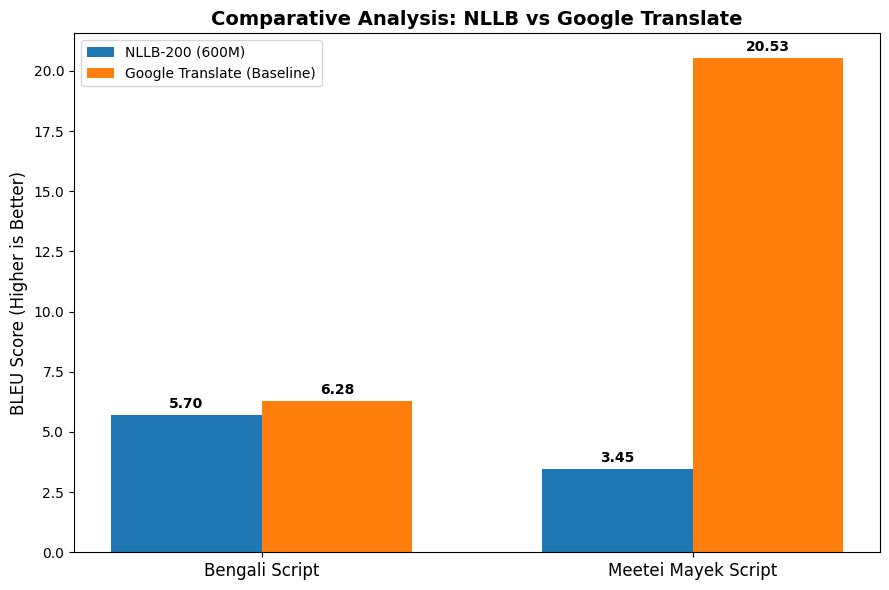

In [10]:
import sacrebleu
import matplotlib.pyplot as plt
import numpy as np

print("Calculating BLEU Scores and Generating Graph...\n")

# Format the "True" original translations for SacreBLEU (must be list of lists)
refs_bengali = [df['True_Manipuri_Bengali'].tolist()]
refs_meetei = [df['True_Manipuri_Meetei'].tolist()]

# Calculate BLEU Scores for Bengali Script
bleu_nllb_beng = sacrebleu.corpus_bleu(df['NLLB_Pred_Bengali'].tolist(), refs_bengali).score
bleu_google_beng = sacrebleu.corpus_bleu(df['Google_Pred_Bengali'].tolist(), refs_bengali).score

# Calculate BLEU Scores for Meetei Mayek
bleu_nllb_meetei = sacrebleu.corpus_bleu(df['NLLB_Pred_Meetei'].tolist(), refs_meetei).score
bleu_google_meetei = sacrebleu.corpus_bleu(df['Google_Pred_Meetei'].tolist(), refs_meetei).score

# Print Exact Scores
print(f"Bengali Script -> NLLB: {bleu_nllb_beng:.2f} | Google: {bleu_google_beng:.2f}")
print(f"Meetei Mayek   -> NLLB: {bleu_nllb_meetei:.2f} | Google: {bleu_google_meetei:.2f}\n")

# --- Draw the Comparative Grouped Bar Chart ---
labels = ['Bengali Script', 'Meetei Mayek Script']
nllb_scores = [bleu_nllb_beng, bleu_nllb_meetei]
google_scores = [bleu_google_beng, bleu_google_meetei]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(9, 6))
rects1 = ax.bar(x - width/2, nllb_scores, width, label='NLLB-200 (600M)', color='#1f77b4')
rects2 = ax.bar(x + width/2, google_scores, width, label='Google Translate (Baseline)', color='#ff7f0e')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BLEU Score (Higher is Better)', fontsize=12)
ax.set_title('Comparative Analysis: NLLB vs Google Translate', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend()

# Attach a text label above each bar displaying its height (the exact score)
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

fig.tight_layout()
plt.show()

